# Clinical History Pipeline

In [14]:
# Imports
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.preprocessing import StandardScaler

In [15]:
# Paths
RAW_PATH = "../data/raw/clinical_history_dataset.csv"
OUT_CLEAN_PATH = "../data/processed/clinical_history_cleaned.csv"
OUT_REPORT_PATH = "../reports/clinical_history_leakage_report.json"

os.makedirs(os.path.dirname(OUT_CLEAN_PATH), exist_ok=True)
os.makedirs(os.path.dirname(OUT_REPORT_PATH), exist_ok=True)

In [16]:
# Load raw data
df_raw = pd.read_csv(RAW_PATH)
print("Shape:", df_raw.shape)
display(df_raw.head(3))
print("\nColumns:", list(df_raw.columns))

Shape: (1205, 12)


,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
0,22,90.0,60.0,9.0,100,18.0,1.0,1.0,0,1,80.0,High
1,22,110.0,70.0,7.1,98,20.4,0.0,0.0,0,0,74.0,Low
2,27,110.0,70.0,7.5,98,23.0,1.0,0.0,0,0,72.0,Low



Columns: ['Age', 'Systolic BP', 'Diastolic', 'BS', 'Body Temp', 'BMI', 'Previous Complications', 'Preexisting Diabetes', 'Gestational Diabetes', 'Mental Health', 'Heart Rate', 'Risk Level']


# Visualizations before cleaning (raw data)

These plots help us see data quality issues (missingness, outliers, unrealistic ranges) before cleaning.
Outputs are saved under 'reports/figures/clinical_history_before_cleaning'.

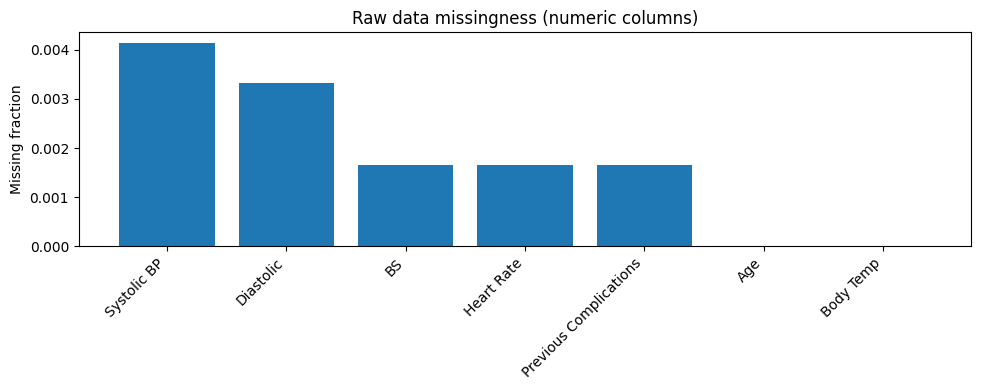

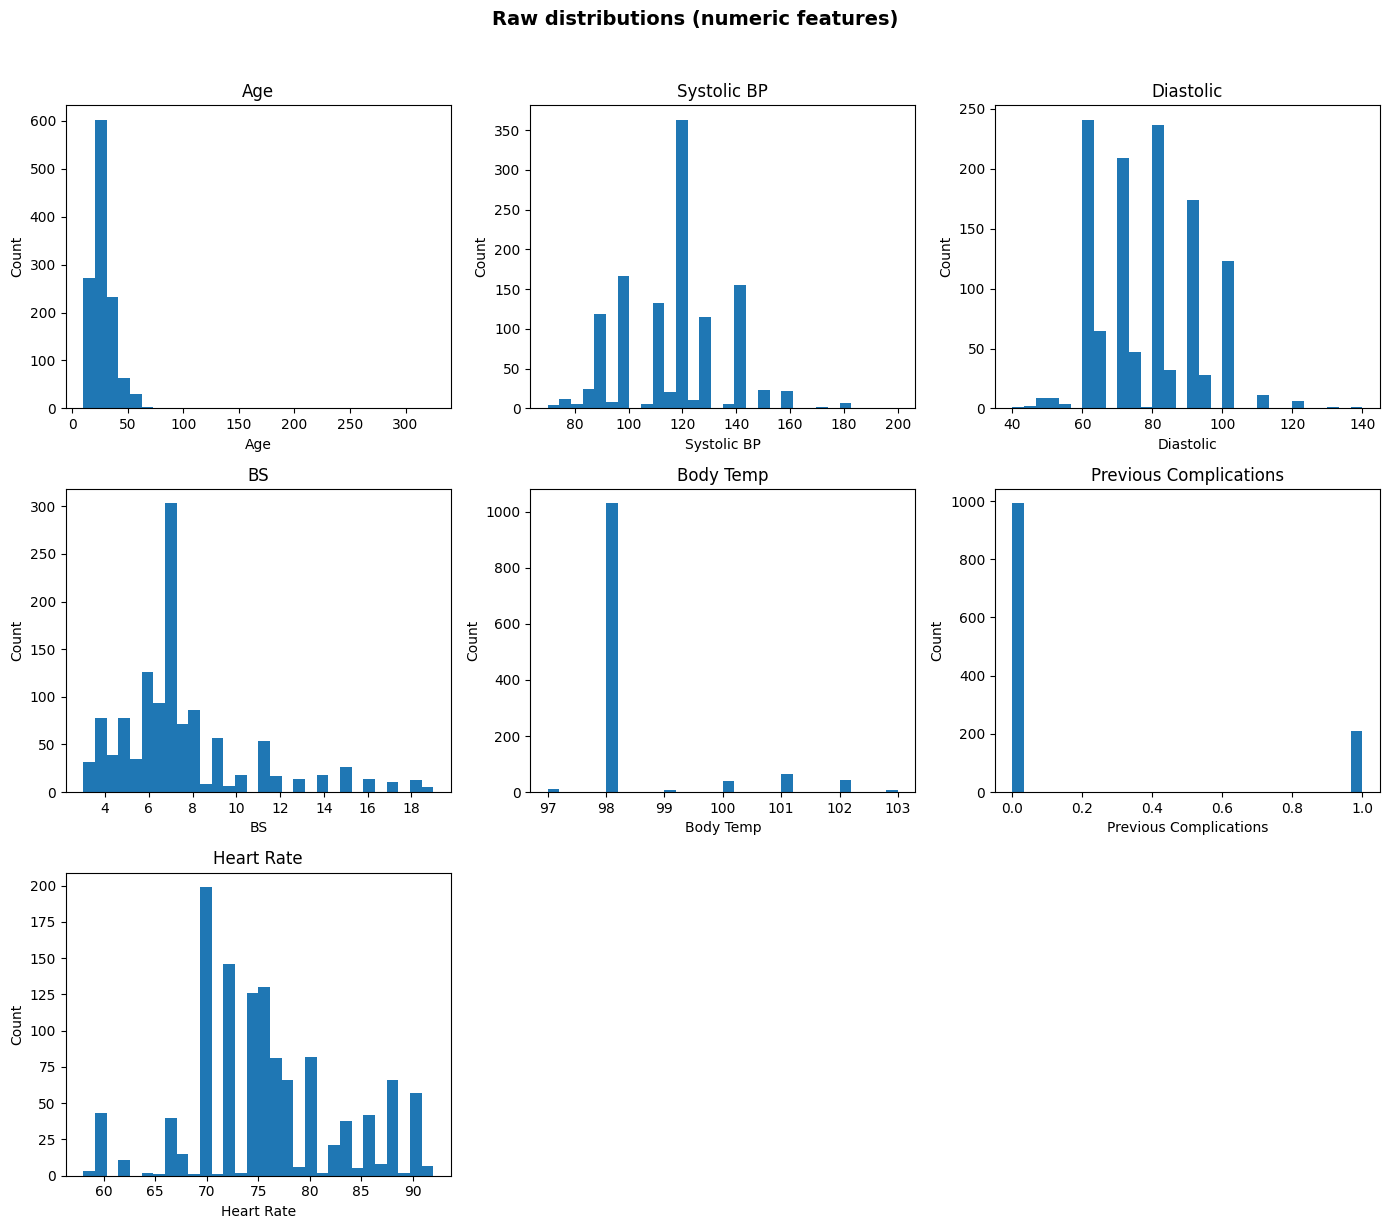

 Saved raw figures to: reports/figures/clinical_history_before_cleaning/


In [17]:
# Visualizations BEFORE cleaning
import math
import matplotlib.pyplot as plt

FIG_DIR = "reports/figures/clinical_history_before_cleaning/"
os.makedirs(FIG_DIR, exist_ok=True)

RAW_NUM_COLS = [
    "Age","Systolic BP","Diastolic","BS","Body Temp","Previous Complications",
    "Heart Rate"
]

# Missingness bar (single figure)
miss = df_raw[RAW_NUM_COLS].isna().mean().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
plt.bar(miss.index, miss.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing fraction")
plt.title("Raw data missingness (numeric columns)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "clinical_raw_missingness.png"), dpi=150)
plt.show()

# Histograms grid
n = len(RAW_NUM_COLS)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(RAW_NUM_COLS):
    ax = axes[i]
    ax.hist(df_raw[col].dropna().values, bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Raw distributions (numeric features)", y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "clinical_raw_hist_grid.png"), dpi=150, bbox_inches="tight")
plt.show()

print(" Saved raw figures to:", FIG_DIR)

# Schema validation

In [18]:
REQUIRED_COLS = [
    "Age","Systolic BP","Diastolic","BS","Body Temp","Previous Complications",
    "Preexisting Diabetes","Gestational Diabetes","Mental Health","Heart Rate",
]

for c in REQUIRED_COLS:
    if c not in df_raw:
        raise ValueError(f"Required column {c} not found in dataset.")

print(" Required columns present.")

 Required columns present.


# Cleaning and feature engineering

Production principles:
- Do not drop rows silently (log counts)
- Convert types deterministically
- Enforce plausible physiological ranges
- Keep a single temperature unit (`temp_celsius`)


In [19]:
df = df_raw.copy()

# Convert to numeric where appropriate
num_cols = [
    "Age","Systolic BP","Diastolic","BS","Body Temp","Previous Complications",
    "Heart Rate"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

bin_cols = ["Preexisting Diabetes","Gestational Diabetes","Mental Health"]
for c in bin_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Basic range sanity
RANGES = {
    "Age": (10, 60),
    "Systolic BP": (60, 250),
    "Diastolic": (30, 150),
    "BS": (40, 400),
    "Body Temp": (30, 43),
    "Previous Complications": (0, 10),
    "Heart Rate": (30, 220),
}

range_report = {}
for col, (lo, hi) in RANGES.items():
    before = df[col].isna().sum()
    df.loc[(df[col] < lo) | (df[col] > hi), col] = np.nan
    after = df[col].isna().sum()
    range_report[col] = {"n_new_nans_from_range_filter": int(after - before), "range": [lo, hi]}

# Impute numeric with median
impute_report = {}
for c in num_cols:
    med = df[c].median()
    n_missing = df[c].isna().sum()
    df[c] = df[c].fillna(med)
    impute_report[c] = {"imputed_missing": int(n_missing), "median_used": float(med)}

# Impute binaries with mode (0/1)
for c in bin_cols:
    mode = df[c].mode(dropna=True)
    mode_val = float(mode.iloc[0]) if len(mode) else 0.0
    n_missing = df[c].isna().sum()
    df[c] = df[c].fillna(mode_val).astype(int)
    impute_report[c] = {"imputed_missing": int(n_missing), "mode_used": int(mode_val)}

print(" Cleaning complete.")
print("Shape:", df.shape)

# Save cleaned data
df.to_csv(OUT_CLEAN_PATH, index=False)
print(" Saved cleaned data to:", OUT_CLEAN_PATH)

 Cleaning complete.
Shape: (1205, 12)
 Saved cleaned data to: ../data/processed/clinical_history_cleaned.csv


# Leakage audit

In [20]:
# Check for obvious target contamination in feature list
FEATURES = [
    "Age","Systolic BP","Diastolic","BS","Body Temp","Previous Complications",
    "Preexisting Diabetes","Gestational Diabetes","Mental Health","Heart Rate",
]
TARGETS = ["hypertension_flag","diabetes_any","high_risk_score"]

leak_feature_overlap = sorted(set(FEATURES).intersection(TARGETS))
print("Overlap between FEATURES and TARGETS:", leak_feature_overlap)

Overlap between FEATURES and TARGETS: []


In [21]:
# Exact-duplicate leakage rate
X_feat = df[FEATURES].copy()
train_X, test_X = train_test_split(X_feat, test_size=0.2, random_state=42)

train_hash = pd.util.hash_pandas_object(train_X, index=False)
test_hash  = pd.util.hash_pandas_object(test_X, index=False)

dup_leak_rate = float(test_hash.isin(set(train_hash)).mean())
print("Exact duplicate leakage rate:", dup_leak_rate)

Exact duplicate leakage rate: 0.2863070539419087


# Visualizations after cleaning

These confirm that cleaning did what we intended and did not distort the data.
Outputs are saved under 'reports/figures/clinical_history_after_cleaning'.

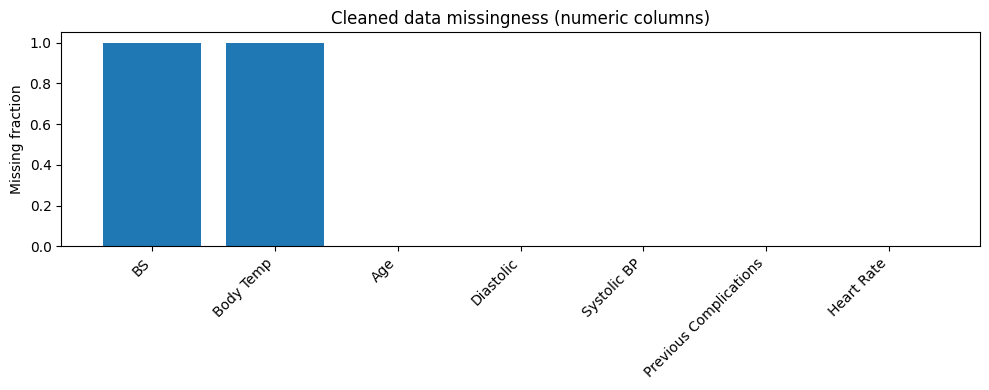

C:\Users\Nicolle School\AppData\Local\Temp\ipykernel_11808\2137520749.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([raw_vals, clean_vals], labels=["raw", "clean"], showfliers=True)
C:\Users\Nicolle School\AppData\Local\Temp\ipykernel_11808\2137520749.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([raw_vals, clean_vals], labels=["raw", "clean"], showfliers=True)
C:\Users\Nicolle School\AppData\Local\Temp\ipykernel_11808\2137520749.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([raw_vals, clean_vals], labels=["raw", "clean"], showfliers=True)
C:\Users\Nicolle School\A

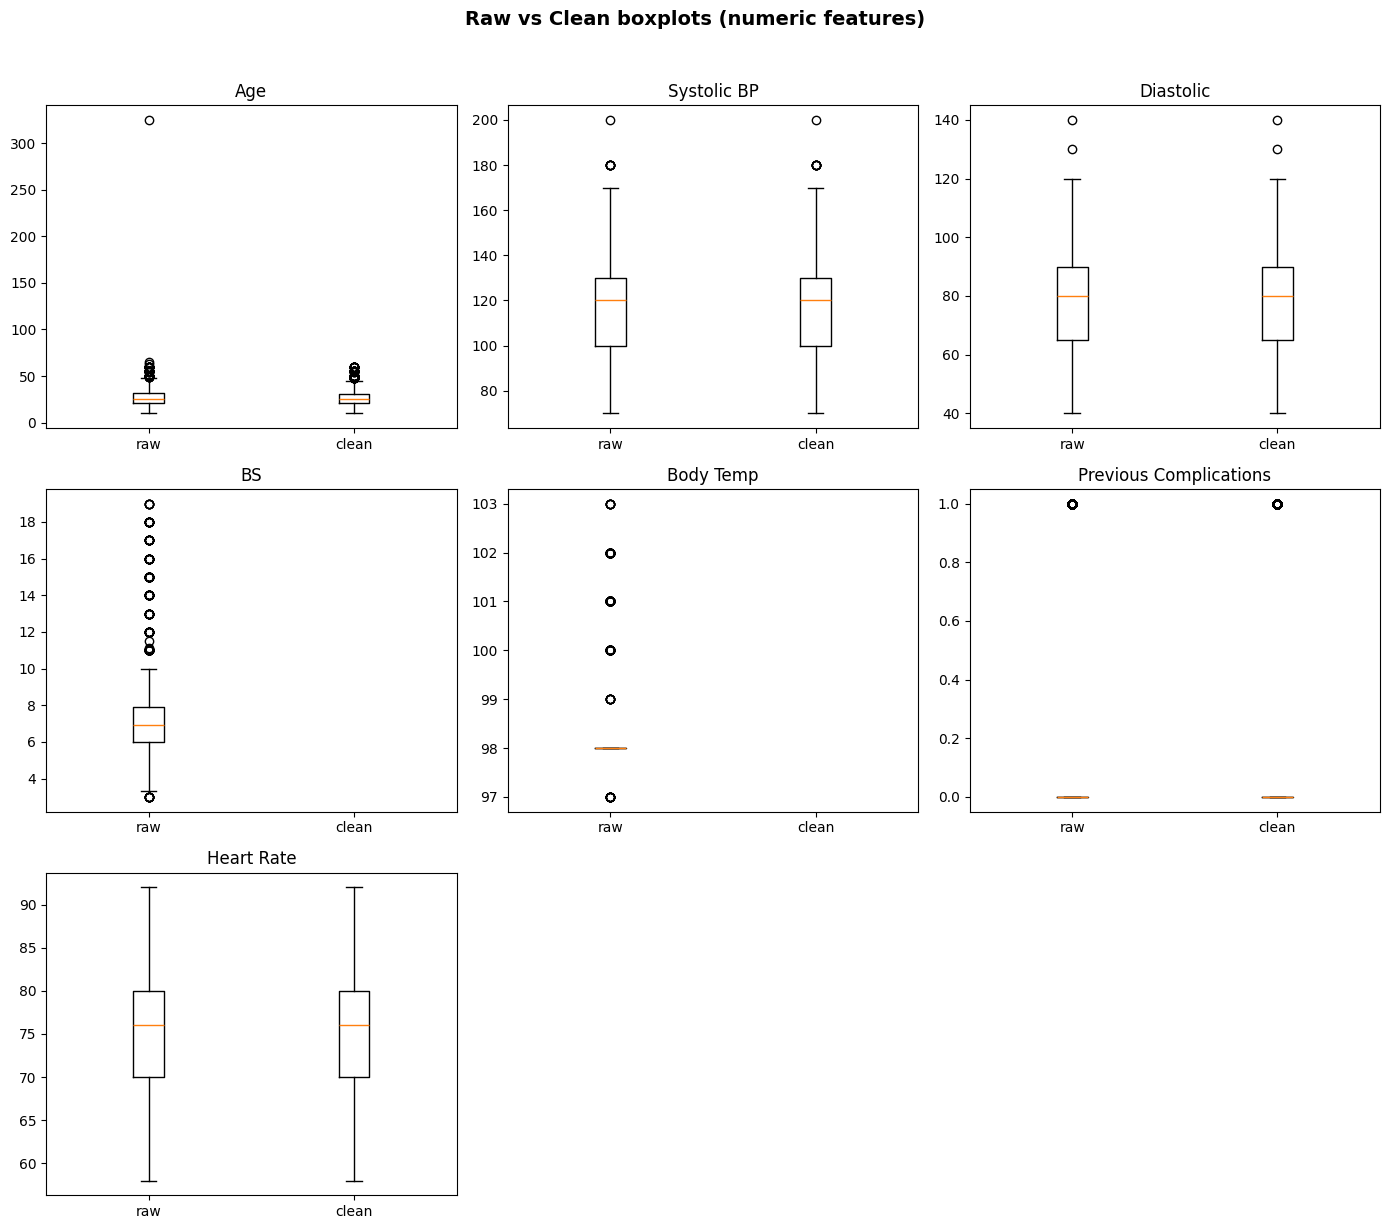

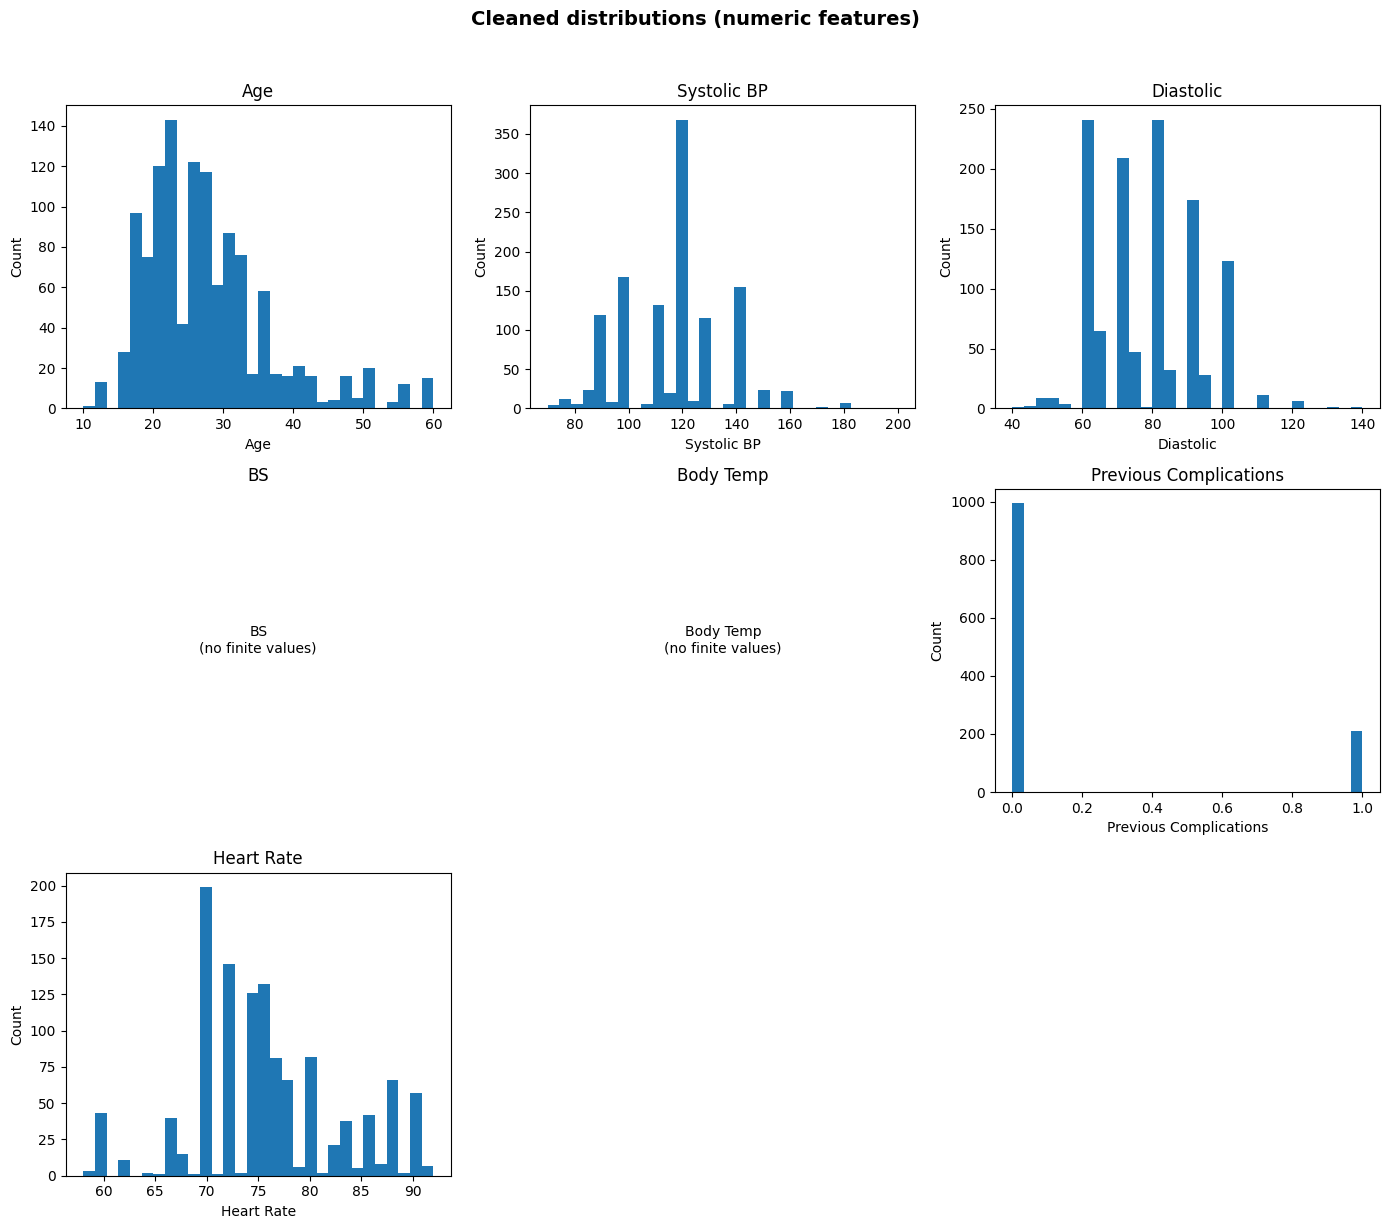

 Saved cleaned figures to: reports/figures/clinical_history_after_cleaning/


In [22]:
# Visualizations AFTER cleaning
import os
import math
import numpy as np
import matplotlib.pyplot as plt

FIG_DIR = "reports/figures/clinical_history_after_cleaning/"
os.makedirs(FIG_DIR, exist_ok=True)

CLEAN_NUM_COLS = [
    "Age","Systolic BP","Diastolic","BS","Body Temp","Previous Complications",
    "Heart Rate"
]

# Missingness bar (single figure)
miss = df[CLEAN_NUM_COLS].isna().mean().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
plt.bar(miss.index, miss.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing fraction")
plt.title("Cleaned data missingness (numeric columns)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "clinical_clean_missingness.png"), dpi=150)
plt.show()

# Boxplots raw vs clean grid (3 columns)
n = len(CLEAN_NUM_COLS)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(CLEAN_NUM_COLS):
    ax = axes[i]
    raw_vals = df_raw[col].dropna().values if col in df_raw.columns else np.array([])
    clean_vals = df[col].dropna().values

    ax.boxplot([raw_vals, clean_vals], labels=["raw", "clean"], showfliers=True)
    ax.set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Raw vs Clean boxplots (numeric features)", y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "clinical_box_raw_vs_clean_grid.png"), dpi=150, bbox_inches="tight")
plt.show()

# Cleaned histograms grid (3 columns)
n = len(CLEAN_NUM_COLS)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(CLEAN_NUM_COLS):
    ax = axes[i]

    # Coerce to numeric + remove non-finite values
    vals = pd.to_numeric(df[col], errors="coerce").to_numpy()
    vals = vals[np.isfinite(vals)]

    if vals.size == 0:
        ax.text(0.5, 0.5, f"{col}\n(no finite values)", ha="center", va="center")
        ax.set_title(col)
        ax.axis("off")
        continue

    ax.hist(vals, bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Cleaned distributions (numeric features)", y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "clinical_clean_hist_grid.png"), dpi=150, bbox_inches="tight")
plt.show()

print(" Saved cleaned figures to:", FIG_DIR)

# Feature Engineering for model training

In [24]:
# Rename to canonical names
RENAME_MAP = {
    "Age": "age",
    "Systolic BP": "systolic_bp",
    "Diastolic": "diastolic_bp",
    "BS": "blood_sugar",
    "Body Temp": "temp_celsius",
    "BMI": "bmi",
    "Previous Complications": "prev_complications",
    "Preexisting Diabetes": "preexist_diabetes",
    "Gestational Diabetes": "gest_diabetes",
    "Mental Health": "mental_health",
    "Heart Rate": "heart_rate",
    "Risk Level": "risk_level"
}
df = df_raw.rename(columns=RENAME_MAP).copy()

# Drop Risk Level before any training features are built
df = df.drop(columns=["risk_level"], errors="ignore")

print(" Columns after dropping Risk Level:", df.columns.tolist())


 Columns after dropping Risk Level: ['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar', 'temp_celsius', 'bmi', 'prev_complications', 'preexist_diabetes', 'gest_diabetes', 'mental_health', 'heart_rate']


# Clinical Encoder training (Self-supervised)

Training a Denoising Autoencoder (DAE):
- Input: scaled clinical features (incl. derived pulse pressure + MAP)
- Output: reconstruct original inputs
- Embedding: 'clinical_embedding' (32 dims)

Artifacts saved under: 'models_artifacts/clinical_encoder/<version>/'
and dataset with embeddings saved to: 'data/processed/clinical_with_embeddings.csv'

In [25]:
# Build encoder feature matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

BASE_FEATURES = [
    "age", "systolic_bp", "diastolic_bp", "blood_sugar", "temp_celsius", "bmi",
    "prev_complications", "preexist_diabetes", "gest_diabetes", "mental_health",
    "heart_rate"
]

# Ensure all base features exist
missing = [c for c in BASE_FEATURES if c not in df.columns]
if missing:
    raise ValueError(f"Missing base features for encoder: {missing}")

# Coerce to numeric (this is the big fix)
df_enc = df.copy()
for c in BASE_FEATURES:
    df_enc[c] = pd.to_numeric(df_enc[c], errors="coerce")

# Replace infinities with NaN
df_enc[BASE_FEATURES] = df_enc[BASE_FEATURES].replace([np.inf, -np.inf], np.nan)

# Median-impute NaNs (column-wise)
medians = df_enc[BASE_FEATURES].median(numeric_only=True)
df_enc[BASE_FEATURES] = df_enc[BASE_FEATURES].fillna(medians)

# Recompute derived features AFTER imputation
df_enc["pulse_pressure"] = df_enc["systolic_bp"] - df_enc["diastolic_bp"]
df_enc["map_mmhg"] = df_enc["diastolic_bp"] + (df_enc["pulse_pressure"] / 3.0)

ENC_FEATURES = BASE_FEATURES + ["pulse_pressure", "map_mmhg"]

# Final finite check
X = df_enc[ENC_FEATURES].values.astype(float)
if not np.isfinite(X).all():
    bad = [ENC_FEATURES[i] for i in np.where(~np.isfinite(X).all(axis=0))[0]]
    raise ValueError(f"Non-finite values remain in: {bad}")

# Scale
enc_scaler = StandardScaler()
X_scaled = enc_scaler.fit_transform(X)

assert np.isfinite(X_scaled).all(), "X_scaled still contains NaN/Inf"
print(" Encoder input shape:", X_scaled.shape)

 Encoder input shape: (1205, 13)


In [26]:
# Build Denoising Autoencoder (32-dim embedding)
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

def build_dae(input_dim, embedding_dim=32, hidden=(128, 64), dropout=0.2, lr=1e-3):
    inp = Input(shape=(input_dim,), name="clinical_input")

    # Encoder
    x = inp
    for h in hidden:
        x = Dense(h, activation="relu")(x)
        x = Dropout(dropout)(x)
    emb = Dense(embedding_dim, activation="relu", name="clinical_embedding")(x)

    # Decoder
    x = emb
    for h in reversed(hidden):
        x = Dense(h, activation="relu")(x)
    out = Dense(input_dim, activation="linear", name="reconstruction")(x)

    auto = Model(inp, out, name="clinical_dae")
    encoder = Model(inp, emb, name="clinical_encoder")

    auto.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    return auto, encoder

def add_noise(x, noise_std=0.15):
    return x + np.random.normal(0, noise_std, size=x.shape)

X_tr, X_te = train_test_split(X_scaled, test_size=0.2, random_state=42)

auto, encoder = build_dae(
    input_dim=X_scaled.shape[1],
    embedding_dim=32,
    hidden=(128, 64),
    dropout=0.2,
    lr=1e-3
)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=6, factor=0.5)
]

history = auto.fit(
    add_noise(X_tr, 0.15), X_tr,
    validation_data=(add_noise(X_te, 0.15), X_te),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("Final train loss:", history.history["loss"][-1])
print("Final val loss  :", history.history["val_loss"][-1])

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8230 - val_loss: 0.7187 - learning_rate: 0.0010
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5216 - val_loss: 0.4821 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3657 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2955 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2591 - val_loss: 0.2523 - learning_rate: 0.0010
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2343 - val_loss: 0.2152 - learning_rate: 0.0010
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2122 - val_loss: 0.1928 - learning_rate: 0.0010
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1991 - val_loss: 0.1665 - learning_rate: 0.0010
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1829 - val_loss: 0.1701 - learning_rate: 0.0010
Epoch 10/200
31/31

# Clinical DAE Training Curve

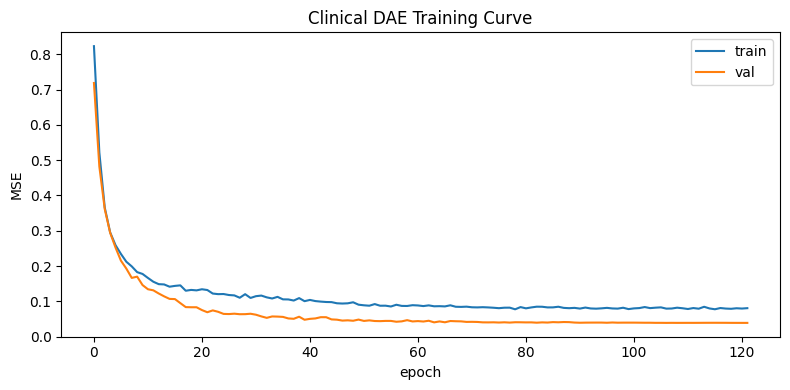

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("epoch"); plt.ylabel("MSE")
plt.title("Clinical DAE Training Curve")
plt.legend()
plt.tight_layout()
plt.savefig("reports/figures/clinical_dae_loss_curve.png", dpi=150)
plt.show()

In [28]:
# Generate embeddings + save dataset for fusion
clinical_emb = encoder.predict(X_scaled, verbose=0)
print("Embedding shape:", clinical_emb.shape)

emb_cols = [f"clin_emb_{i}" for i in range(clinical_emb.shape[1])]
df_emb = pd.DataFrame(clinical_emb, columns=emb_cols)

df_with_emb = pd.concat([df.reset_index(drop=True), df_emb], axis=1)

OUT_EMB_PATH = "data/processed/clinical_with_embeddings.csv"
os.makedirs(os.path.dirname(OUT_EMB_PATH), exist_ok=True)
df_with_emb.to_csv(OUT_EMB_PATH, index=False)

print(" Saved:", OUT_EMB_PATH)

Embedding shape: (1205, 32)
 Saved: data/processed/clinical_with_embeddings.csv


In [29]:
# Save encoder artifacts
import os, json, joblib
from datetime import datetime

version = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = f"models_artifacts/clinical_encoder/{version}"
os.makedirs(out_dir, exist_ok=True)

encoder.save(os.path.join(out_dir, "encoder.h5"))
auto.save(os.path.join(out_dir, "autoencoder.h5"))
joblib.dump(enc_scaler, os.path.join(out_dir, "scaler.pkl"))

meta = {
    "features": ENC_FEATURES,
    "embedding_dim": int(clinical_emb.shape[1]),
    "train_samples": int(X_tr.shape[0]),
    "val_samples": int(X_te.shape[0]),
    "noise_std": 0.15
}

with open(os.path.join(out_dir, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

print(" Saved encoder artifacts to:", out_dir)

 Saved encoder artifacts to: models_artifacts/clinical_encoder/20260220_002200
